# LangChain

In [1]:
pip install python-dotenv langchain[groq]

In [2]:
from google.colab import userdata # to import the data although using os for importing the api key
import os
os.environ['GROQ_API_KEY'] = userdata.get('GroqAPIKey')

from langchain.chat_models import init_chat_model

model = init_chat_model("moonshotai/kimi-k2-instruct-0905", model_provider="groq")

In [ ]:
model.invoke("Funny and iconic interview response bits by F1 driver Daniel Ricciardo")

BadRequestError: Error code: 400 - {'error': {'message': 'The model `qwen-2.5-32b` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}

In [ ]:
response = model.invoke("Tell me about F1 driver Daniel Ricciardo")
print(response.content)

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
model.invoke("Hello")

model.invoke([{"role": "user", "content": "Hello"}])

model.invoke([HumanMessage("Hello")])

In [ ]:
response = model.invoke("Tell me one famous one liner of daniel ricciardo.")
print(response.content)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "Tell me one famous one liner of {f1_driver}"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

In [ ]:
prompt = prompt_template.invoke({"f1_driver": "Daniel Ricciardo", "text": "Hey there, F1 Fan!"})
prompt

In [ ]:
prompt_template = ChatPromptTemplate.from_template("Tell me one famous one liner of {f1_driver}")
prompt = prompt_template.invoke({"f1_driver": "Daniel Ricciardo"})
print(prompt)

# Chaining

In [ ]:
from langchain_core.output_parsers import StrOutputParser

one_liner_by_f1_drivers = prompt_template|model|StrOutputParser()

In [ ]:
one_liner_by_f1_drivers.invoke({"f1_driver": "Lewis Hamilton"})


# LangGraph

In [1]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 18.0 MB/s eta 0:00:00


In [3]:
from langgraph.graph import StateGraph


In [10]:
def func1(inp):
  x, y = inp["x"], inp["y"]
  # Instead of returning x+y, return a dictionary to update the state
  return {"x": x+y, "y": y}

def func2(inp):
  # func2 also needs to accept the state and return a dictionary
  return {"x": 2 * inp["x"], "y": inp["y"]}

In [11]:
from typing import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        x: A number.
        y: A number.
    """
    x: float
    y: float


workflow = StateGraph(GraphState)

workflow.add_node("func1", func1)
workflow.add_node("func2", func2)

workflow.add_edge("func1", "func2")

workflow.set_entry_point("func1")


app = workflow.compile()

In [12]:
app.invoke({"x": 1, "y": 2})

{'x': 6, 'y': 2}

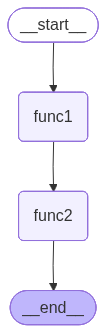

In [13]:
from IPython.display import Image, display

try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

# Customer Support App

In [3]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [4]:
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display , Image

In [5]:
from typing import TypedDict
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response : str

In [6]:
llm = model
llm.invoke("who is Daniel Ricciardo?")

AIMessage(content='Daniel Ricciardo is an Australian racing driver best known for competing in Formula 1. Born on July 1, 1989, in Perth, Australia, he’s raced for several teams, most notably Red Bull Racing, where he won seven Grands Prix between 2014 and 2018. He’s also driven for Renault, McLaren, and, as of 2023, is a reserve driver for Red Bull Racing after a stint with AlphaTauri. Ricciardo is widely recognized for his aggressive overtaking style, late-braking maneuvers, and charismatic personality, often referred to as “the honey badger” in the F1 paddock.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 33, 'total_tokens': 170, 'completion_time': 0.464923711, 'prompt_time': 0.010038998, 'queue_time': 0.050879601, 'total_time': 0.474962709}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9b346cf4-e239-47c

In [18]:

# We are using the same llm, normally we can use different llms. we can take different kind of llms from HF and fine tune according to the purpose it will be addressing from the user.

def categorize(state:State) -> State:
  prompt = ChatPromptTemplate.from_template("Categorize the following query into one of the following categories:"
  "Technical, Billing, General. Query:{query}")
  chain = prompt| llm
  category = chain.invoke({"query": state["query"]}).content
  print(f"\n{category}")
  return {"category": category}

def analyse_sentiment(state:State) -> State:
  prompt = ChatPromptTemplate.from_template("Analyze the sentiment of the following customer query and ans in word"
      "Response with either 'Positive', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt| llm
  sentiment = chain.invoke({"query": state["query"]}).content
  print(f"\n{sentiment}")
  return {"sentiment": sentiment}

def handle_technical(state:State) -> State:
  prompt = ChatPromptTemplate.from_template("Provide a technical support response to the following query: {query}")
  chain = prompt| llm
  response = chain.invoke({"query": state["query"]}).content
  print(f"\n{response}")
  return {"response": response}

def handle_billing(state:State) -> State:
  prompt = ChatPromptTemplate.from_template("Provide a billing support response to the following query: {query}")
  chain = prompt| llm
  response = chain.invoke({"query": state["query"]}).content
  print(f"\n{response}")
  return {"response": response}

def handle_general(state:State) -> State:
  prompt = ChatPromptTemplate.from_template("Provide a general support response to the following query: {query}")
  chain = prompt| llm
  response = chain.invoke({"query": state["query"]}).content
  print(f"\n{response}")
  return {"response": response}

def escalate(state:State) -> State:
  print("Escalating Query")
  return {"response": "This query has been escalated to a human agent due to its negative sentiment"}

def route_query(state:State) -> State:
  if state["sentiment"].lower() == "negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"





In [25]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyse_sentiment", analyse_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_conditional_edges("analyse_sentiment", route_query)

workflow.add_edge("categorize", "analyse_sentiment")
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app = workflow.compile()

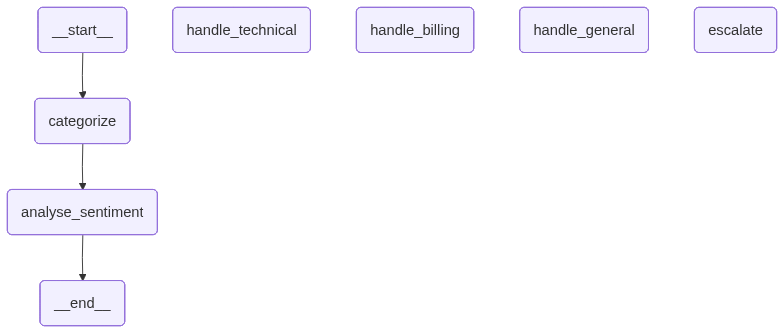

In [26]:
from IPython.display import Image, display

try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [27]:
 def run_customer_support(query:str) -> Dict[str, str]:
  results = app.invoke({"query": query})
  return {
      "category": results["category"],
      "sentiment": results["sentiment"],
      "response": results["response"]
  }

In [31]:
query = "My ferrari f1 chassis is facing some brake issues SF-25"
result = run_customer_support(query)
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Technical

Neutral

Ferrari F1 Customer Support – Case ID: SF-25-BRK-2024-06  
Chassis: SF-25 / VIN# F170-25-013  

Dear [Customer Name],

Thank you for contacting us through the SF-25 secure telemetry channel. Our factory engineers have already pulled the last 6 GB of CAN data from your chassis and can confirm that the brake‐by-wire ECU is flagging a recurring “BBW-2174 – Front-axle hydraulic offset outside tolerance” every 3–4 laps. This is almost certainly the root cause of the inconsistent pedal feel and the 0.14 s/lap loss you reported.  

Below is the recommended track-side procedure; if you are not running the latest Ferrari F1 client software (v25.6.8.3) please update first, as earlier versions do not expose the offset-trim function.

1. Pre-track checklist (10 min)  
   a. Bleed both front calipers with the specified 312 °C Brembo RBF-1100 fluid; we saw traces of 3.9 % water content in your last sample—above the 2 % limit.  
   b. Verify the Brembo sensor offset shim (P/N 270

#